In [1]:
#processing
import numpy as np
from collections import Counter

#io
import time
from decimal import Decimal
import matplotlib.pyplot as plt

#MD-specific
import westpa
from westpa.analysis import Run
import pyemma

#my classes (unused)
#import westpa_h5_reader_msm_functions as hmf
#import weighted_msms


In [2]:
#TODO: identify branch points (filtered by some age or descendant number or PC threshold) 
# and pull out branch point frames on x01 for inspection

In [3]:
#used as an adapter between my MSM construction and pyemma's
class msm():
    def __init__(self, eqp, sio):
        self.stationary_distribution = eqp
        self.active_set = sio

In [4]:

cftr_west = "/home/jonathan/Documents/grabelab/cftr/chloe-data"
cftr_refpc = "/home/jonathan/Documents/grabelab/cftr/refeaturization"

#can we make this read in the bounds from a west.cfg file?
h5paths_names = [ [f"{cftr_west}/wstp_cftr_1_degrabo/west-040925.h5", f"{cftr_refpc}/nonlip_glpg_1", "pyrazole-1",  "blue",   0, 2000, [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  [f"{cftr_west}/wstp_cftr_2_wynton/west-040925.h5",  f"{cftr_refpc}/nonlip_glpg_2", "pyrazole-2",  "cyan",   0, 1000, [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  [f"{cftr_west}/wstp_lip_glpg_1/west-040925.h5",     f"{cftr_refpc}/lip_glpg_1",    "undecanol-1", "red",    0, 2000, [0, 1, 3, 5, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 24, 25, 25.5, 26, 26.5, 27,28,29,30,32,34,36,38, 40, 50]],
                  [f"{cftr_west}/wstp_lip_glpg_2/west-040925.h5",     f"{cftr_refpc}/lip_glpg_2",    "undecanol-2", "orange", 0, 2000, [0,1,1.3,1.5,1.7,2,2.2,2.4,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,25.5,26,26.5,27,28,29,30,32,34,36,38,40,41,50]]
]

we_ind = 2
threshold = 15

h5path  = h5paths_names[we_ind][0]
miniter = h5paths_names[we_ind][4]
maxiter = h5paths_names[we_ind][5]

1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100


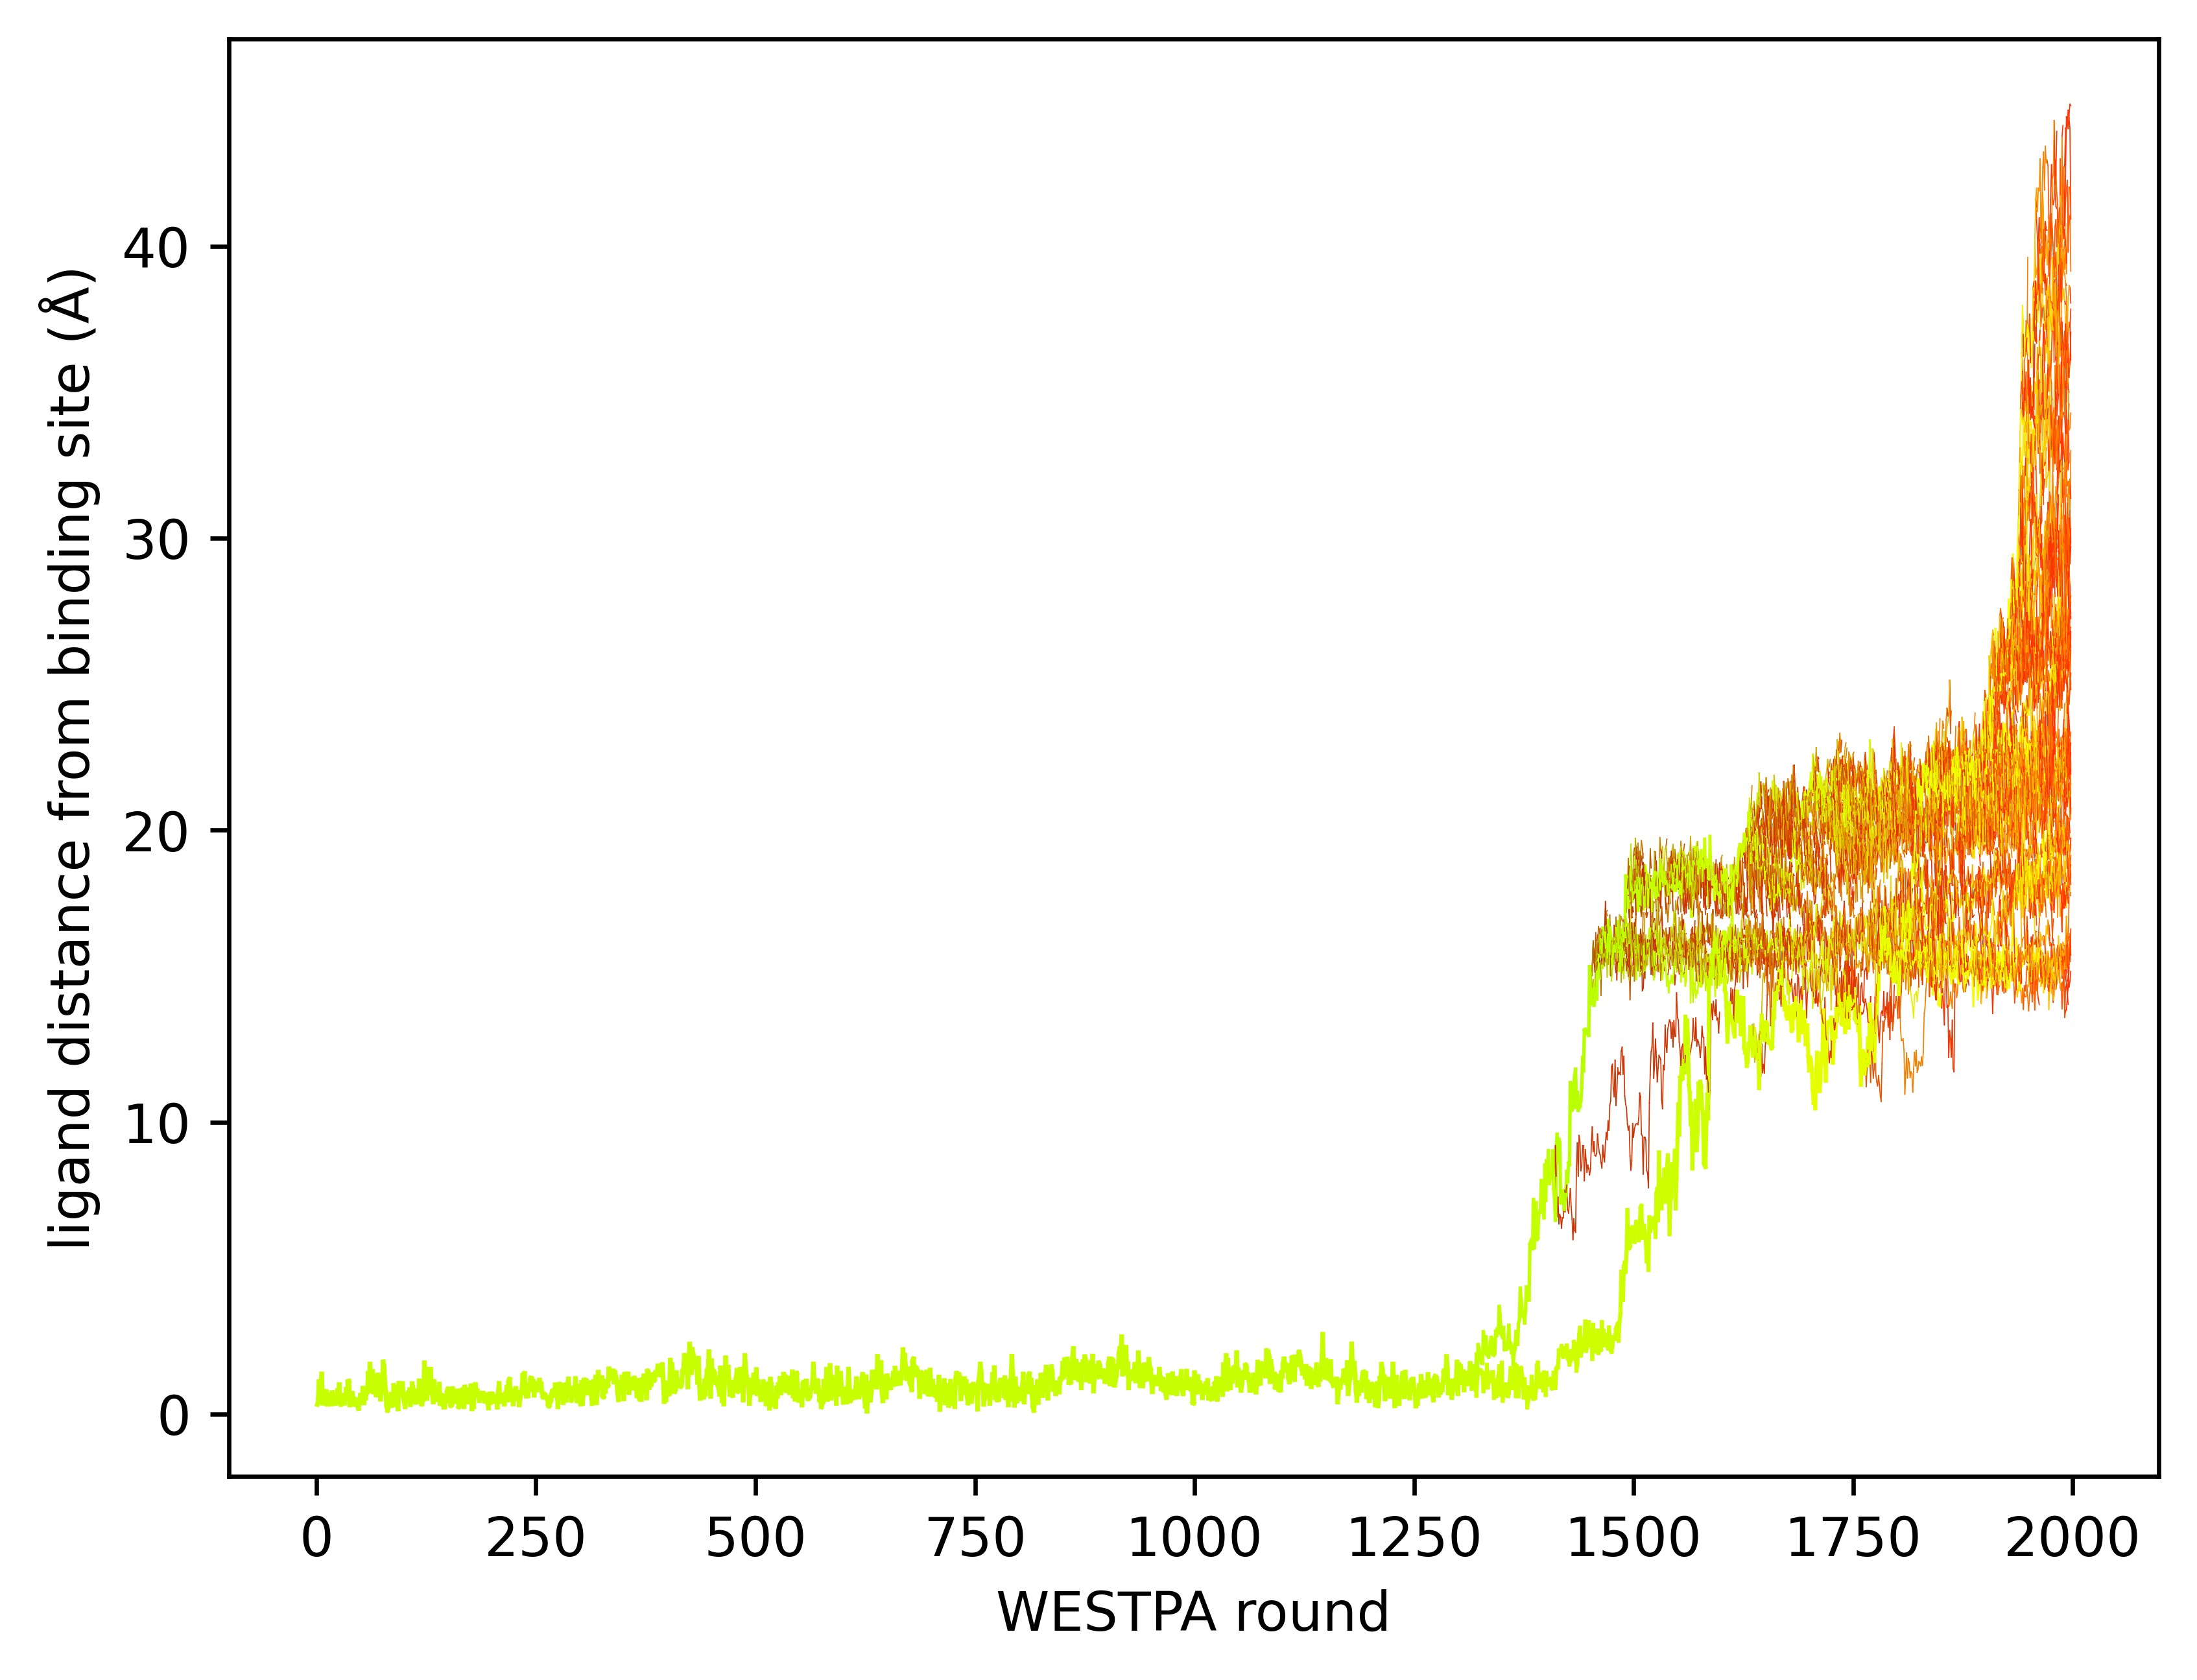

In [7]:

def h5_2_pcs(h5path, miniter, maxiter, threshold):
    
    run = Run.open(h5path)

    #set maximum iteration automatically
    if maxiter == -1:
        maxiter = run.num_iterations

    #collect matching arrays of the progress coordinate of each walker and its parent in the previous round
    #i.e. parent_pcs[i] contains the pc of the parent of the walker whose pc is recorded at pcs[i]
    pcs = []
    parent_pcs = []
    weights = []     #for parent walkers

    #initial progress coordinate (only collected if miniter <= 1)
    pc_init = []

    iters_all = [iteration for iteration in run]

    active_set = []
    active_set_colors = []

    fig, ax = plt.subplots()
    fig.set_dpi(600)
    
    #loop over all WESTPA rounds
    for iteration in reversed(iters_all):

        #check if current iteration is in the correct range
        if iteration.number < miniter:
            if iteration.number == 1:
                #initial pc
                pc_init = [[wa.parent.pcoord] for wa in iteration.walkers][0][-1]            
            break
        elif iteration.number >= maxiter:
            continue

        if iteration.number%100 == 0:
            print(iteration.number)
        
        #collect PCs for current round
        pcs.append(iteration.pcoords)

        #collect PCs for parents of walkers in current round
        #note that these are collected as lists of 2d arrays rather than 3d arrays
        #    they are stacked rather than concatenated at the end to achieve the same output shape
        if iteration.number == 1:
            #for the first round there is no parent walker in the regular sense 
            #     but the pcoord is recorded under a slightly different variable name
            #     weight is similarly recorded differently
            #parent_pcs.append(np.stack([[wa.parent.pcoord, wa.parent.pcoord] for wa in iteration.walkers]))
            #weights.append([wa.parent.basis_state.probability for wa in iteration.walkers])
            
            #initial pc
            #pc_init = parent_pcs[-1][-1]

            for wa in iteration.walkers:
                #print(wa.pcoords)
                pc = wa.pcoords[-1][0]
                #print(pc)
                if wa.index in active_set or pc > threshold:

                    if wa.index in active_set:
                        color = active_set_colors[wa.index]
                        color_out = (active_set_colors[wa.index][0], active_set_colors[wa.index][1]/(1+active_set_colors[wa.index][1]), active_set_colors[wa.index][2])
                    else:
                        color = (iteration.number/2000, 1/4, 0)
                        color_out = color
                        
                    ax.plot([iteration.number-1, iteration.number], [wa.parent.pcoord[0], pc], color=color_out, linewidth = 1/5)
            
        else:
            new_active_set_colors = []
            new_active_set = []
            
            for wa in iteration.walkers:
                #print(wa.pcoords)
                pc = wa.pcoords[-1][0]
                #print(pc)
                if wa.index in active_set or pc > threshold:

                    if wa.index in active_set:
                        color = active_set_colors[wa.index]
                        color_out = (active_set_colors[wa.index][0], active_set_colors[wa.index][1]/(1+active_set_colors[wa.index][1]), active_set_colors[wa.index][2])
                        #color_out = (active_set_colors[wa.index][0], 0, active_set_colors[wa.index][2])
                        ax.plot([iteration.number-1, iteration.number], [wa.parent.pcoords[-1][0], pc], color=color_out, linewidth = color[1]/(1000+color[1]) + 1/5)

                    else:
                        color = (iteration.number/2000, 1/4, 0)
                        #color_out = color
                    
                    new_active_set_colors.append(color + (iteration.number, pc))
                    #print(color + (iteration.number, pc))
                    new_active_set.append(wa.parent.index)

            active_set = []
            active_set_colors = {}
            #active_set_colors = [] 
            for nas, nasc in zip(new_active_set, new_active_set_colors):
                if nas not in active_set:
                    active_set.append(nas)
                    active_set_colors[nas] = [nasc]
                else:
                    active_set_colors[nas].append(nasc)
    
            #if iteration.number%100 == 0:
            #    print(active_set_colors)
            
            for k in active_set_colors.keys():
                avgcolor = (np.mean([c[0] for c in active_set_colors[k]]), np.sum([c[1] for c in active_set_colors[k]]), np.mean([c[2] for c in active_set_colors[k]]))
                active_set_colors[k] = avgcolor
                # if len(active_set_colors[k]) > 1:
                #     print(active_set_colors[k])
                #     plt.plot(active_set_colors[k][0][3], active_set_colors[k][0][4], marker=".")
                
            #if iteration.number%100 == 0:
            #    print(active_set_colors)   
            #    print("-------------------------------------------------------------------------------------------")

            # active_set = new_active_set #"...and the torch has been passed to a new iteration..."
            # active_set_colors = new_active_set_colors # color revolution


            #print([wa.parent.index for wa in iteration.walkers])
            
            #not everything appears in .__dict__
            #parent_pcs.append(np.stack([wa.parent.pcoords for wa in iteration.walkers]))
            #weights.append([wa.parent.weight for wa in iteration.walkers])


    #return pcs, parent_pcs, weights, pc_init, maxiter

    plt.xlabel("WESTPA round")
    plt.ylabel("ligand distance from binding site (Å)")
    plt.savefig("lip-WE-1-tree", dpi=600)

#red is average round at which descendants which reach threshold; redder = later
#green and thickness are total number of descendants up until reaching threshold; greener and thicker = more

h5_2_pcs(h5path, miniter, maxiter, threshold)

In [6]:
fig, ax = plt.subplots()
fig.set_dpi(300)
ax.plot([0,1],[2.5,3], color = (, 1, 0), linewidth=1/5)

SyntaxError: invalid syntax (4250673715.py, line 3)